In [1]:
import tensorflow as tf
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [4]:
data_dir = 'datasetfull'

In [5]:
import numpy as np

In [6]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(360, 360))

Found 10298 files belonging to 5 classes.


In [7]:
classes = data.class_names
print(classes)

['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']


In [8]:
def cropes(image):
    return tf.image.crop_to_bounding_box(image, 90, 90, 200, 200)

In [9]:
#data = data.map(lambda x, y: (x/360, y))
data = data.map(lambda x, y: (cropes(x), y))

In [37]:
batch_it = data.as_numpy_iterator()

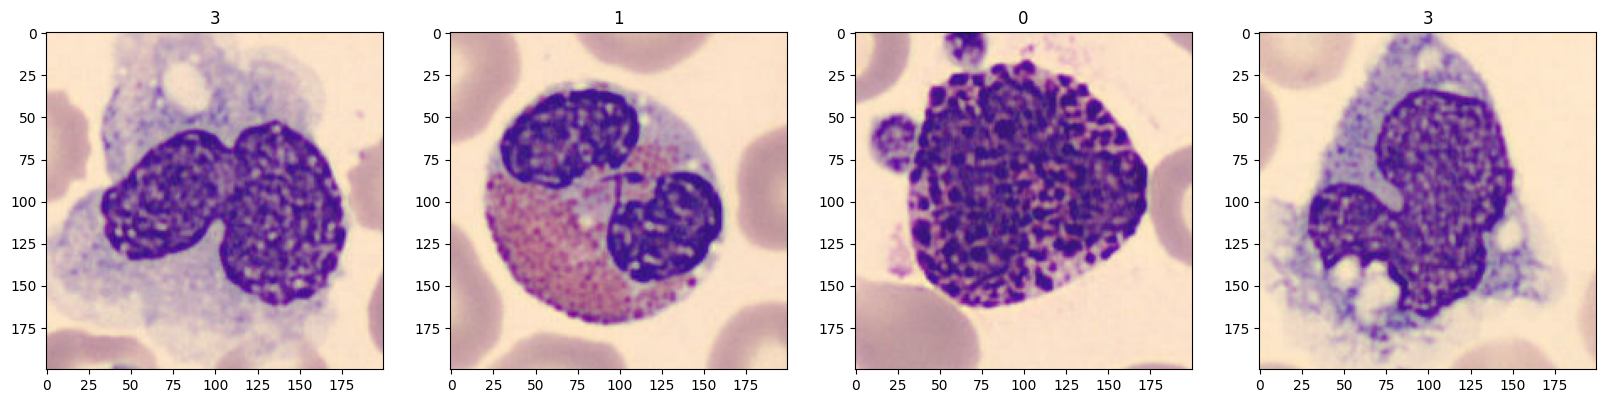

In [38]:
batch = batch_it.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])



In [12]:
print(len(data))
train_size = int(len(data)*.7)
valid_size = int(len(data)*.2)
test_size = int(len(data) - (train_size+valid_size))
print(train_size+valid_size+test_size)

322
322


In [13]:
train = data.take(train_size)
val = data.skip(train_size).take(valid_size)
test = data.skip(train_size+valid_size).take(test_size)
print(len(train))
print(len(val))
print(len(test))

225
64
33


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [19]:
model = Sequential()

In [20]:
model.add(Conv2D(8, (3,3), 1, activation='relu', input_shape=(200,200,3)))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(360, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [21]:
model.compile('adam', loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 198, 198, 8)       224       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 99, 99, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 97, 97, 16)        1168      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 32)      

In [23]:
hist = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
225/225 [==============================] - 19s 63ms/step - loss: 1.3972 - sparse_categorical_accuracy: 0.7992 - val_loss: 0.2585 - val_sparse_categorical_accuracy: 0.9126
Epoch 2/20
225/225 [==============================] - 14s 62ms/step - loss: 0.1710 - sparse_categorical_accuracy: 0.9450 - val_loss: 0.1322 - val_sparse_categorical_accuracy: 0.9565
Epoch 3/20
225/225 [==============================] - 14s 63ms/step - loss: 0.0998 - sparse_categorical_accuracy: 0.9681 - val_loss: 0.1774 - val_sparse_categorical_accuracy: 0.9429
Epoch 4/20
225/225 [==============================] - 14s 61ms/step - loss: 0.0722 - sparse_categorical_accuracy: 0.9760 - val_loss: 0.0884 - val_sparse_categorical_accuracy: 0.9722
Epoch 5/20
225/225 [==============================] - 14s 64ms/step - loss: 0.0429 - sparse_categorical_accuracy: 0.9847 - val_loss: 0.1205 - val_sparse_categorical_accuracy: 0.9658
Epoch 6/20
225/225 [==============================] - 14s 62ms/step - loss: 0.0360 - spars

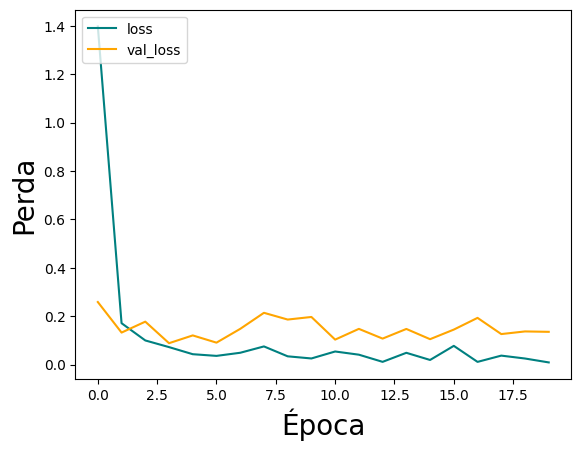

In [24]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label = 'loss')
plt.plot(hist.history['val_loss'], color='orange', label = 'val_loss')
plt.legend(loc='upper left')
plt.xlabel('Época',fontsize=20)
plt.ylabel('Perda',fontsize=20)
plt.show()

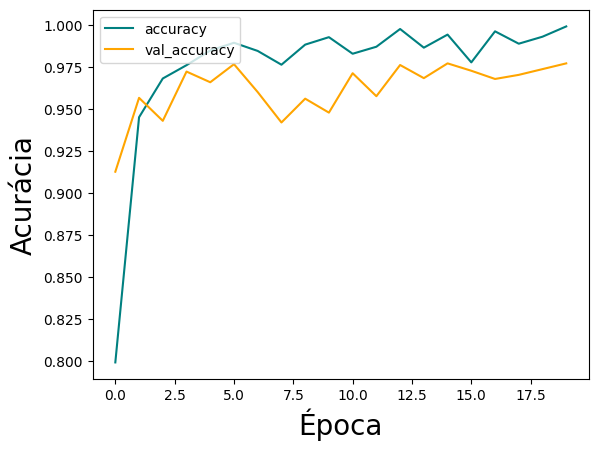

In [25]:
fig = plt.figure()
plt.plot(hist.history['sparse_categorical_accuracy'], color='teal', label = 'accuracy')
plt.plot(hist.history['val_sparse_categorical_accuracy'], color='orange', label = 'val_accuracy')
plt.legend(loc='upper left')
plt.xlabel('Época',fontsize=20)
plt.ylabel('Acurácia',fontsize=20)
plt.show()

In [26]:
#7

In [27]:
model.save(os.path.join('models','Classify_White_Blood_Cell_Final_Cropped.h5'))

In [ ]:
from tensorflow.keras.models import load_model
model = load_model(os.path.join('models','Classify_White_Blood_Cell_Final_Cropped.h5'))

In [28]:
from tensorflow.keras.metrics import Recall, Precision, Accuracy
from sklearn.metrics import classification_report

In [30]:
recall = Recall()
precision = Precision()
accuracy = Accuracy()

y_true = []
y_pred = []

for btch in test.as_numpy_iterator():
    X, y = btch
    b = np.zeros((y.size, y.max() + 1))
    b[np.arange(y.size), y] = 1
    yhat = model.predict(X)
    recall.update_state(b, yhat)
    precision.update_state(b, yhat)
    accuracy.update_state(b, yhat)
    for i in y:
        y_true.append(y[i])
        y_pred.append(np.argmax(yhat[i]))
    
print(f'Recall: {recall.result().numpy()}')
print(f'Precision: {precision.result().numpy()}')
print(f'Accuracy: {accuracy.result().numpy()}')

1/1 [==============================] - 0s 134ms/step
Recall: 0.9800000190734863
Precision: 0.980934202671051
Accuracy: 0.10514285415410995


In [ ]:
Recall: 0.9833005666732788
Precision: 0.9862068891525269
Accuracy: 0.13025540113449097

In [ ]:
print(len(y_true))
print(len(y_pred))

In [31]:
from sklearn.metrics import confusion_matrix

In [32]:
cm = confusion_matrix(y_true, y_pred)

In [33]:
cm

array([[ 89,   3,   0,   0,   7],
       [  0, 391,   0,   0,   0],
       [  0,   6, 107,   0,   0],
       [  8,   0,   0, 131,   0],
       [  0,   0,   0,   0, 308]], dtype=int64)

In [34]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

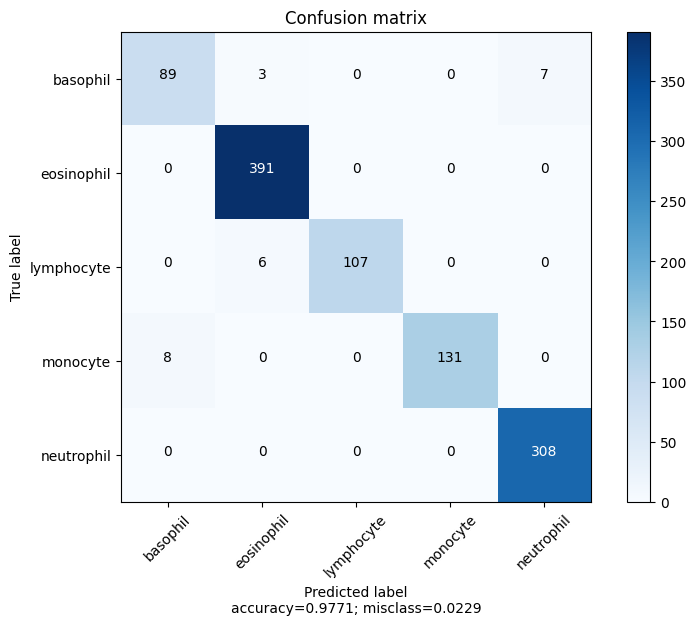

              precision    recall  f1-score   support

    basophil       0.92      0.90      0.91        99
  eosinophil       0.98      1.00      0.99       391
  lymphocyte       1.00      0.95      0.97       113
    monocyte       1.00      0.94      0.97       139
  neutrophil       0.98      1.00      0.99       308

    accuracy                           0.98      1050
   macro avg       0.97      0.96      0.97      1050
weighted avg       0.98      0.98      0.98      1050



In [35]:
plot_confusion_matrix(cm, classes, normalize=False)
print(classification_report(y_true, y_pred, target_names=classes))

In [36]:
#8

In [ ]:
import cv2

fig, ax = plt.subplots(ncols=5, figsize=(30,30))

img1 = cv2.cvtColor(cv2.imread(os.path.join('test', 'basophil', 'BA_990612.jpg')), cv2.COLOR_BGR2RGB)
resize = tf.image.resize(img1, (360,360))
ax[0].imshow(img1)
ax[0].title.set_text('img1')
new_pred = model.predict(np.expand_dims(resize,0))
print(new_pred)
print(new_pred.round(2))
print(classes[np.argmax(new_pred)])


img2 = cv2.cvtColor(cv2.imread(os.path.join('test', 'eosinophil', 'EO_27.jpg')), cv2.COLOR_BGR2RGB)
resize = tf.image.resize(img2, (360,360))
ax[1].imshow(img2)
ax[1].title.set_text('img2')
new_pred = model.predict(np.expand_dims(resize,0))
print(new_pred)
print(new_pred.round(2))
print(classes[np.argmax(new_pred)])


img3 = cv2.cvtColor(cv2.imread(os.path.join('test', 'lymphocyte', 'LY_985583.jpg')), cv2.COLOR_BGR2RGB)
resize = tf.image.resize(img3, (360,360))
ax[2].imshow(img3)
ax[2].title.set_text('img3')
new_pred = model.predict(np.expand_dims(resize,0))
print(new_pred)
print(new_pred.round(2))
print(classes[np.argmax(new_pred)])


img4 = cv2.cvtColor(cv2.imread(os.path.join('test', 'monocyte', 'MO_770459.jpg')), cv2.COLOR_BGR2RGB)
resize = tf.image.resize(img4, (360,360))
ax[3].imshow(img4)
ax[3].title.set_text('img4')
new_pred = model.predict(np.expand_dims(resize,0))
print(new_pred)
print(new_pred.round(2))
print(classes[np.argmax(new_pred)])


img5 = cv2.cvtColor(cv2.imread(os.path.join('test', 'neutrophil', 'BNE_825578.jpg')), cv2.COLOR_BGR2RGB)
resize = tf.image.resize(img5, (360,360))
ax[4].imshow(img5)
ax[4].title.set_text('img5')
new_pred = model.predict(np.expand_dims(resize,0))
print(new_pred)
print(new_pred.round(2))
print(classes[np.argmax(new_pred)])


In [ ]:
#9

In [ ]:
from tensorflow.keras.models import load_model
new_model = load_model(os.path.join('models','Classify_White_Blood_Cell_1K.h5'))

In [ ]:

img = cv2.cvtColor(cv2.imread(os.path.join('test', 'lymphocyte', 'LY_329937.jpg')), cv2.COLOR_BGR2RGB)
resize = tf.image.resize(img, (360,360))
new_pred = new_model.predict(np.expand_dims(resize,0))
print(new_pred)
print(new_pred.round(2))
plt.title(classes[np.argmax(new_pred)])
plt.imshow(img)
plt.show()